In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

In [2]:
dfs = pd.read_csv('data/seat_summary.csv')
dfs.head()

,seat,year,turnout,turnout_pc,voters,male_voters,female_voters,centers
0,Bagerhat-1,1991,128668.0,59.8,NaN,NaN,NaN,NaN
1,Bagerhat-2,1991,127664.0,61.3,NaN,NaN,NaN,NaN
2,Bagerhat-3,1991,99223.0,56.6,NaN,NaN,NaN,NaN
3,Barguna-1,1991,110705.0,45.3,NaN,NaN,NaN,NaN
4,Barguna-2,1991,69037.0,54.1,NaN,NaN,NaN,NaN


In [3]:
# only take 1991-2008 election data
years = [1991, 1996, 2001, 2008]
dfs = dfs[dfs.year.isin(years)]

In [4]:
bdmap = gpd.read_file('map/seats.shp')

In [5]:
# merge map data and seat summary data
df = pd.merge(bdmap, dfs, how='left', on='seat')[['seat', 'division', 'year', 'turnout_pc', 'geometry']]
df.head()

,seat,division,year,turnout_pc,geometry
0,Panchagarh-1,Rangpur,1991,62.10,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,Panchagarh-1,Rangpur,1996,81.81,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
2,Panchagarh-1,Rangpur,2001,86.15,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
3,Panchagarh-1,Rangpur,2008,91.70,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
4,Panchagarh-2,Rangpur,1991,60.40,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."


In [6]:
# group data by seats and count instances of each seat and median of turnout %
dfmed = df[['seat', 'turnout_pc']].groupby('seat').agg(past_tpc_avg=('turnout_pc', 'mean')).reset_index()
dfmed.head()

,seat,past_tpc_avg
0,Bagerhat-1,78.45
1,Bagerhat-2,78.65
2,Bagerhat-3,75.80
3,Bagerhat-4,NaN
4,Bandarban,NaN


In [7]:
# join data with map data
map_tpc = pd.merge(bdmap, dfmed, how='left', on='seat')[['seat', 'geometry', 'division', 'past_tpc_avg']]
map_tpc.head()

,seat,geometry,division,past_tpc_avg
0,Panchagarh-1,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",Rangpur,80.44
1,Panchagarh-2,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",Rangpur,78.80
2,Thakurgaon-1,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",Rangpur,82.11
3,Thakurgaon-2,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",Rangpur,80.35
4,Thakurgaon-3,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",Rangpur,81.30


In [8]:
# get 2026 election data
dfl = pd.read_csv('https://raw.githubusercontent.com/muhallilahnaf/election-2026-live/master/data/seat_votes_pa.csv')

# get latest timestamp data
seat_latest = dfl.groupby('seat')['time'].max().reset_index()
df_latest = pd.merge(dfl, seat_latest, how='inner', on=['seat', 'time'])
df_latest.head()

,seat_no,name,vote,party,alliance,seat,district,division,region,voters,male_voters,female_voters,thirdgender_voters,time,vote_pc
0,95,কপিল কৃষ্ণ মন্ডল,114323,BNP,BNP,Bagerhat-1,Bagerhat,Khulna,Rural,375560.0,190838.0,184720.0,2.0,2026-02-14 14:42:37.115645+00:00,30.44
1,95,মোঃ মশিউর রহমান খান,117527,Jamaat,Jamaat-NCP,Bagerhat-1,Bagerhat,Khulna,Rural,375560.0,190838.0,184720.0,2.0,2026-02-14 14:42:37.115645+00:00,31.29
2,96,শেখ মোহাম্মদ জাকির হোসেন,66409,BNP,BNP,Bagerhat-2,Bagerhat,Khulna,Urban,338009.0,167739.0,170265.0,5.0,2026-02-14 14:42:37.115645+00:00,19.65
3,96,শেখ মনজুরুল হক (রাহাদ),117709,Jamaat,Jamaat-NCP,Bagerhat-2,Bagerhat,Khulna,Urban,338009.0,167739.0,170265.0,5.0,2026-02-14 14:42:37.115645+00:00,34.82
4,97,শেখ ফরিদুল ইসলাম,103711,BNP,BNP,Bagerhat-3,Bagerhat,Khulna,Rural,266864.0,132350.0,134510.0,4.0,2026-02-14 14:42:37.115645+00:00,38.86


In [9]:
dflt = df_latest.groupby('seat').agg(turnout=('vote', 'sum'), voters=('voters', 'first')).reset_index()
dflt.head()

,seat,turnout,voters
0,Bagerhat-1,231850,375560.0
1,Bagerhat-2,184118,338009.0
2,Bagerhat-3,187416,266864.0
3,Bagerhat-4,214393,380679.0
4,Bandarban,167617,315422.0


In [10]:
dflt['tpc'] = (dflt['turnout'] / dflt['voters'] * 100).round(2)
dflt.head()

,seat,turnout,voters,tpc
0,Bagerhat-1,231850,375560.0,61.73
1,Bagerhat-2,184118,338009.0,54.47
2,Bagerhat-3,187416,266864.0,70.23
3,Bagerhat-4,214393,380679.0,56.32
4,Bandarban,167617,315422.0,53.14


In [11]:
dftpc = pd.merge(map_tpc, dflt[['seat', 'tpc']], how='left', on='seat')
dftpc.head()

,seat,geometry,division,past_tpc_avg,tpc
0,Panchagarh-1,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",Rangpur,80.44,74.23
1,Panchagarh-2,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",Rangpur,78.80,72.69
2,Thakurgaon-1,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",Rangpur,82.11,74.24
3,Thakurgaon-2,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",Rangpur,80.35,69.61
4,Thakurgaon-3,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",Rangpur,81.30,61.72


C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-p

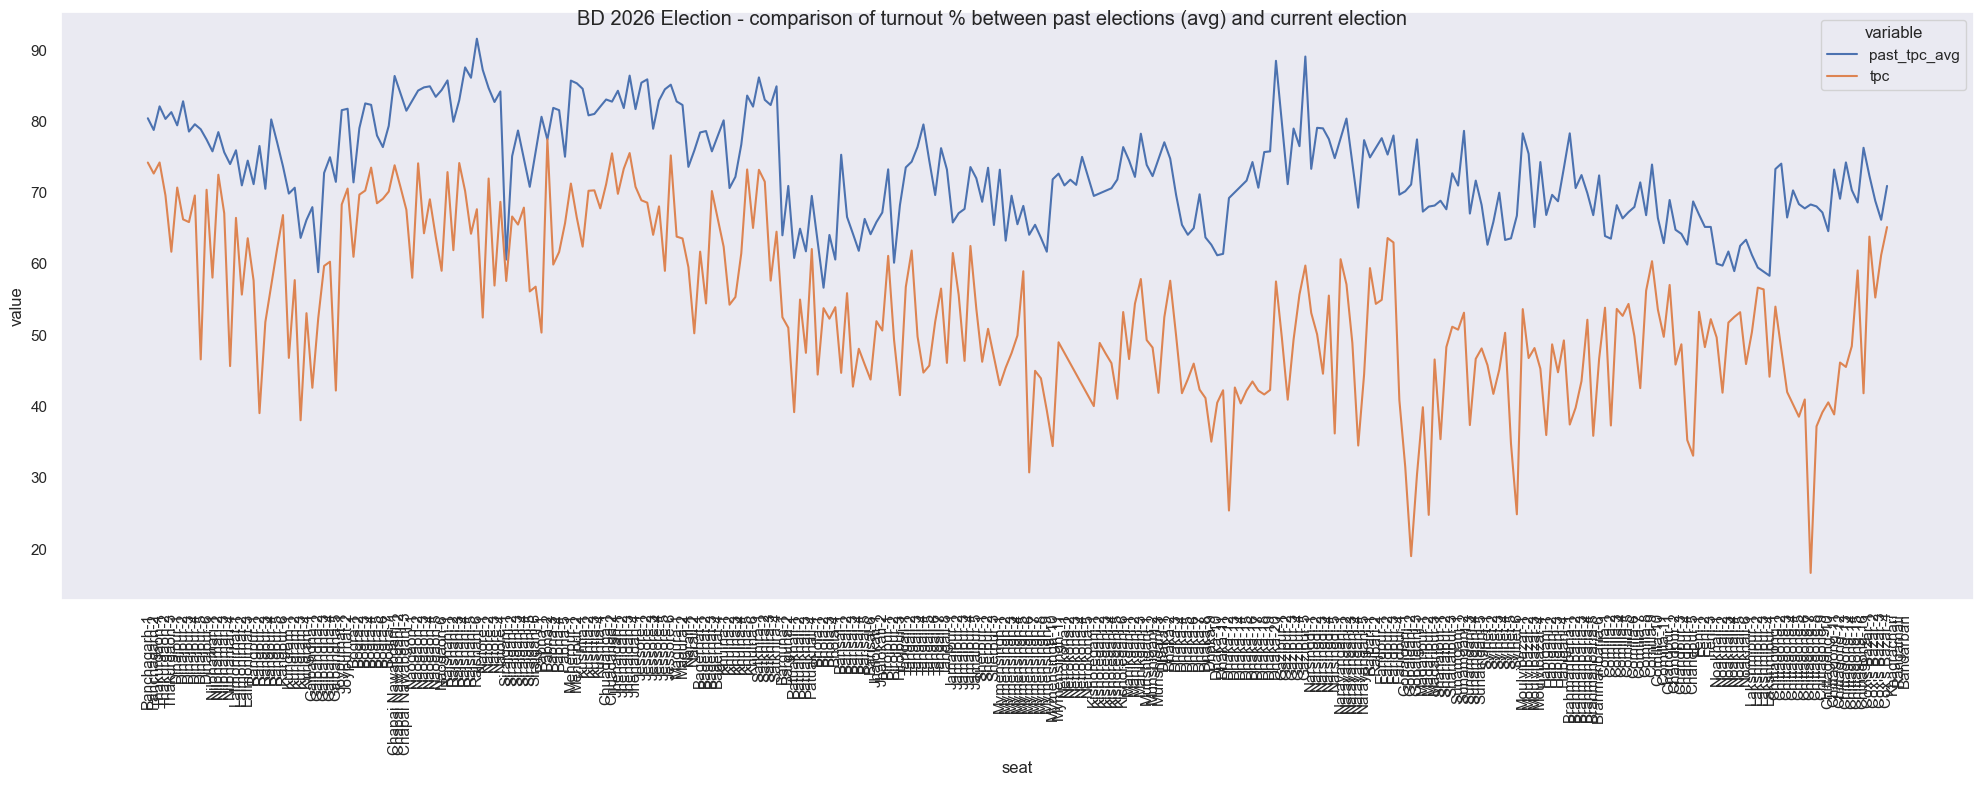

In [36]:
# plot turnout % comparison between past elections (avg) and current election
dftpc_melted = dftpc[['seat', 'past_tpc_avg', 'tpc']].melt(id_vars=['seat'])
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x='seat', y='value', hue='variable', data=dftpc_melted, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(False)
fig.tight_layout()
plt.suptitle('BD 2026 Election - comparison of turnout % between past elections (avg) and current election')
fig.savefig('fig/election_2026_turnout_pc_compare',bbox_inches='tight')
plt.show()

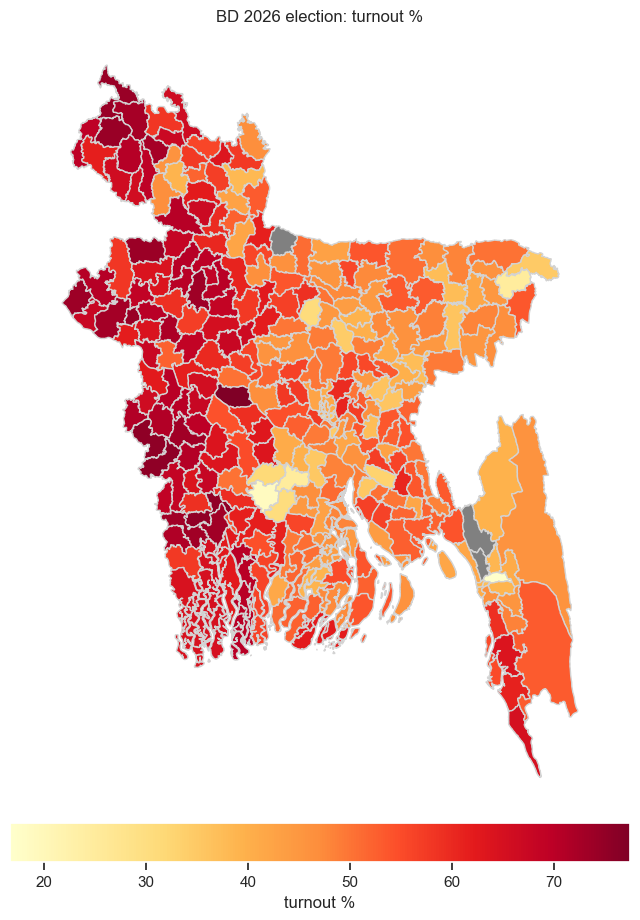

In [12]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

dftpc.plot(
    column='tpc', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'turnout %',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD 2026 election: turnout %")
fig.savefig('fig/election_2026_turnout_pc_map',bbox_inches='tight')

In [41]:
dfvg = df_latest.groupby('seat').agg(winner=('vote', 'max'), nearest=('vote', 'min')).reset_index()
dfvg['vote_gap'] = dfvg['winner'] - dfvg['nearest']
dfvg.head()

,seat,winner,nearest,vote_gap
0,Bagerhat-1,117527,114323,3204
1,Bagerhat-2,117709,66409,51300
2,Bagerhat-3,103711,83705,20006
3,Bagerhat-4,116067,98326,17741
4,Bandarban,141455,26162,115293


In [47]:
# comparison of turnout % and vote gap
dftpcvg = pd.merge(dftpc, dfvg, how='outer', on='seat').sort_values(by='tpc')
scaler = StandardScaler()
dftpcvg[['tpc_z', 'vote_gap_z']] = scaler.fit_transform(dftpcvg[['tpc', 'vote_gap']])
dftpcvg_melted = dftpcvg[['seat', 'tpc_z', 'vote_gap_z']].melt(id_vars=['seat'])
dftpcvg_melted.head()

,seat,variable,value
0,Chittagong-7,tpc_z,-3.144328
1,Gopalganj-2,tpc_z,-2.943578
2,Madaripur-2,tpc_z,-2.448962
3,Sylhet-6,tpc_z,-2.442128
4,Dhaka-12,tpc_z,-2.396852


C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-p

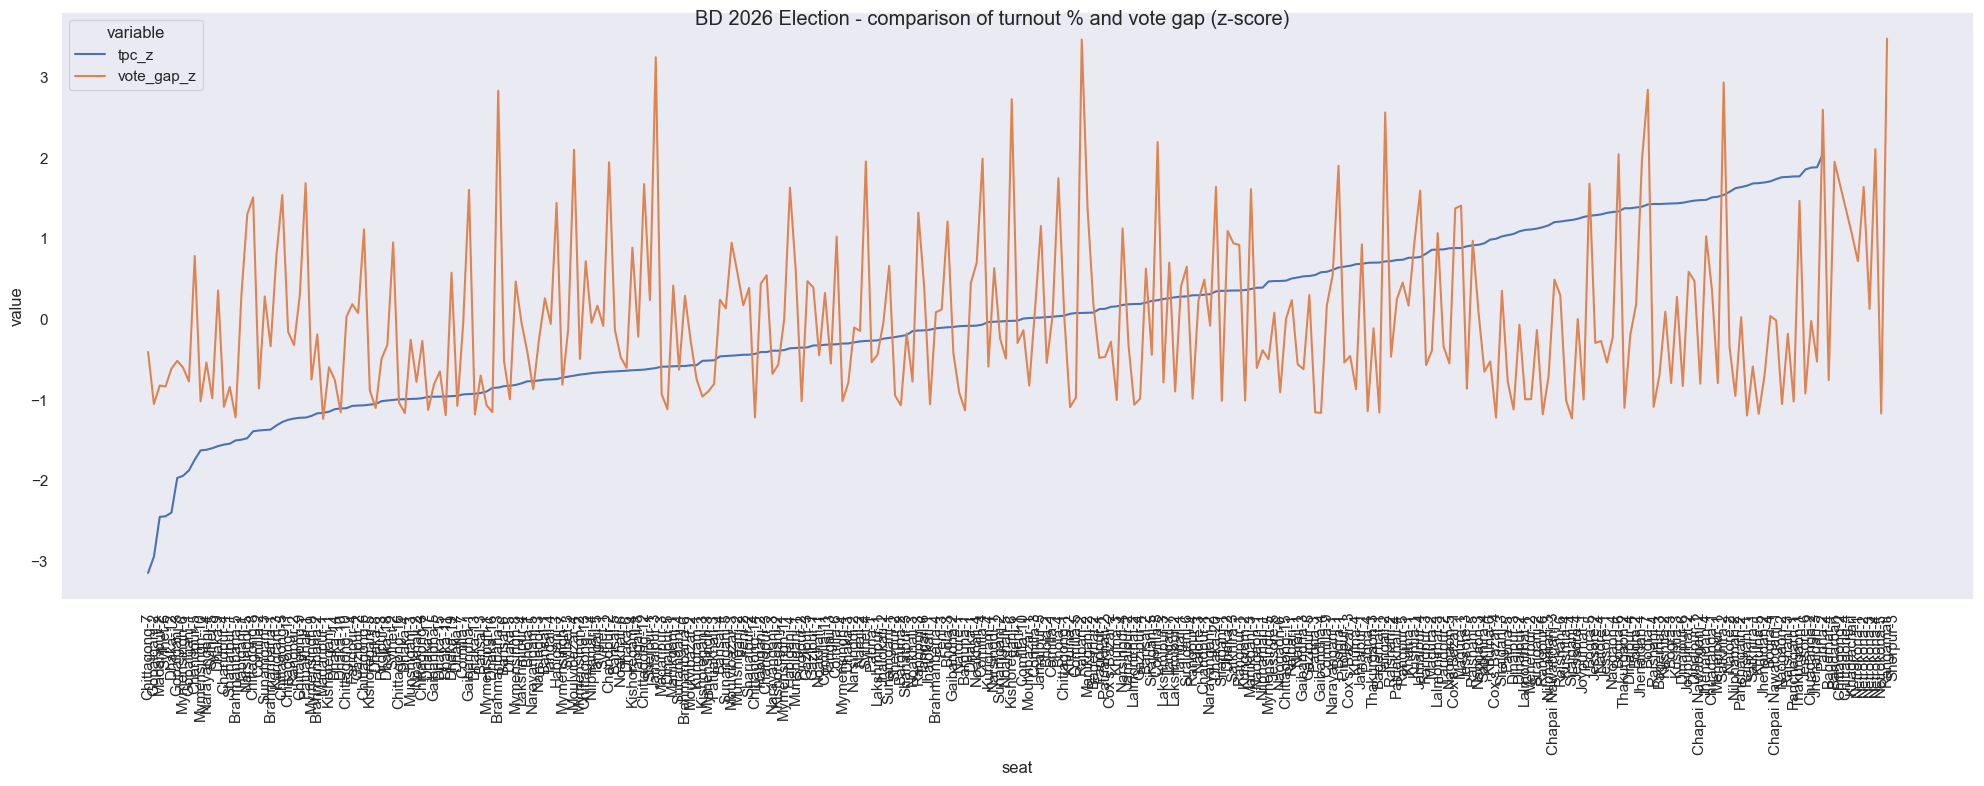

In [48]:
# plot comparison of turnout % and vote gap
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x='seat', y='value', hue='variable', data=dftpcvg_melted, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(False)
fig.tight_layout()
plt.suptitle('BD 2026 Election - comparison of turnout % and vote gap (z-score)')
fig.savefig('fig/election_2026_comparison_turnout_pc_vote_gap',bbox_inches='tight')
plt.show()